## Mackey-Glass equation - 1D example

The Mackey-Glass equation considers the population of mature blood cells, x(t), and models the process of the production of these cells. It has the following delay differential equation (DDE) system:

```math
\begin{align}
  \dot{x}&= \frac{\beta x(t-\tau)}{1+[x(t-\tau)]^n}- \gamma x(t)\\
\end{align}
```
where β expresses the dependence of blood cell production on the number of matrure cells already in the system; where γ is the death rate of mature cells and where τ is the delay between the production of blood cells in the bone marrow and the time taken to release these into the system (blood stream).

The following packages and functions are needed:

In [46]:
using CairoMakie
using LinearAlgebra
include("mackeyglassfunc.jl") #system of Mackey-Glass equation
include("mackeytau.jl") #Delay forumla for Mackey-Glass equation
include("f_deriv.jl") #used to find state and/or parameter derivatives
include("jacobian_new.jl") #Jacobian function
include("newton_new.jl") #Newton function
include("F_eq.jl") #Initialisates a function to find equilibria 
include("track_curve_new.jl") #Tracking curve function (used for continuation and equilibria branches)
include("stab_func.jl") #finds stability and eigenvalues (and eigenvector and ω is interested in Hopf bifurcation)
include("create_hopffunc.jl") #finds initial guess for Hopf information and creates a function that can find the true Hopf values

create_hopffunc (generic function with 1 method)

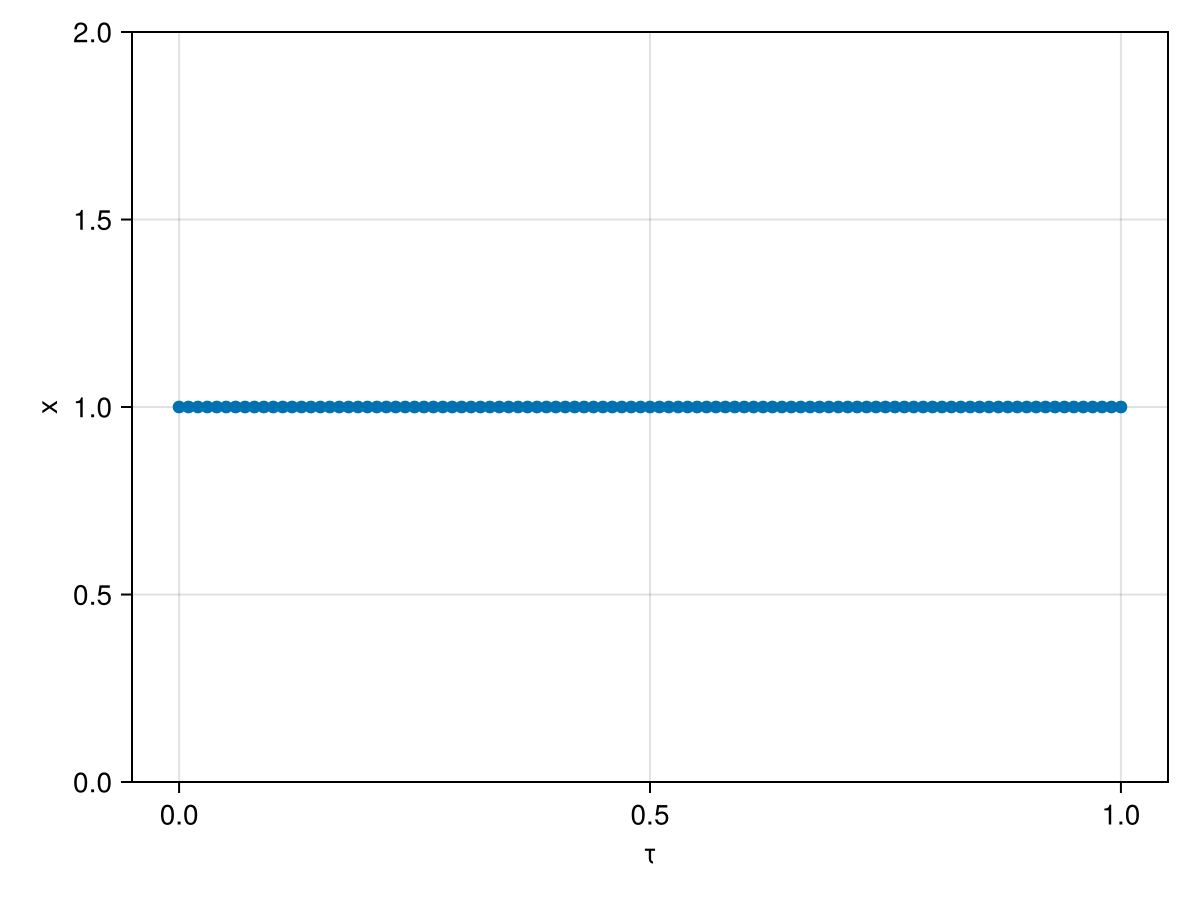

In [47]:
gamma=1.0
#initial states for following parameters (obtained from DDE-Biftool example)
beta=2 #try beta=3 for a change
n=10 #n=3 gives γ/β >=1-2/n so all of x should be stable (By Gupta source)
tau=0
x0=((beta-gamma)/(gamma))^(1/n) #obtained from solving f(x*,...,x*)=0 problem
nd=1 #one delay

y01,feq=F_eq(mackeyglassfunc, x0, [beta,gamma,n,tau],nd, par_indx=4) #finds initial equilibrium point and creates a function to find the equilibria branch
ylist1,ytan1=track_curve_new(feq,y01,[0.0,1],stepsize=0.01,nmax=100) #tracks equilibria to find the equilibria branch

#Below plots the equilibiria branch
fig1=Figure()
ax1=Axis(fig1[1,1],xlabel="τ",ylabel="x")
scatter!(ax1,[u[2] for u in ylist1],[u[1] for u in ylist1])
lines!(ax1,[u[2] for u in ylist1],[u[1] for u in ylist1])
fig1

In [48]:
#check that f(x*,...x*,pars)=0
feq(y01)

1-element Vector{Float64}:
 0.0

# Stability

Finding the stability of equilibiria of DDEs is more complex than finding the stability of equilibria of ODEs due to the infinite dimensional past. For this example the stability was found by using a large matrix that can be used to create a finite-dimensional system that can approximate the stability of the equilibria - for more details look at ```stab_func```. The function ``` stab_func ``` has a first output of 1 is the equilibrium point if stable and has 0 if it is unstable. Below we find the stability of one equilibrium point:

In [49]:
#stability of an equilibrium point
stab_func(mackeyglassfunc,mackeytau, [x0], [0.4],[gamma,beta,n,tau], [4], nd, doprint=1)

(1, ComplexF64[-486.6443159194875 + 0.0im, -486.18302611848276 - 14.786984412209483im, -486.18302611848276 + 14.786984412209483im, -484.8009390965779 - 29.5166099503731im, -484.8009390965779 + 29.5166099503731im, -482.5033950836204 - 44.13173934350201im, -482.5033950836204 + 44.13173934350201im, -479.29927144429337 - 58.575677666874775im, -479.29927144429337 + 58.575677666874775im, -475.2009482429103 - 72.7923913687723im  …  -16.96036821249703 - 63.17032744046449im, -16.96036821249703 + 63.17032744046449im, -12.830555667381196 - 48.573045787450695im, -12.830555667381196 + 48.573045787450695im, -9.371065016542632 - 33.718355653460286im, -9.371065016542632 + 33.718355653460286im, -6.290519408053984 - 18.62524812491093im, -6.290519408053984 + 18.62524812491093im, -1.7833392917704947 - 4.032566044790832im, -1.7833392917704947 + 4.032566044790832im], ComplexF64[0.001330788602784538 + 0.0im 0.001330759488654777 - 4.064149041508388e-5im … -0.0036048896431045392 - 0.06709548624977106im -0.0036

We now find the stability for all the points on the equilibria branch, which are given in the vector ```stab```:

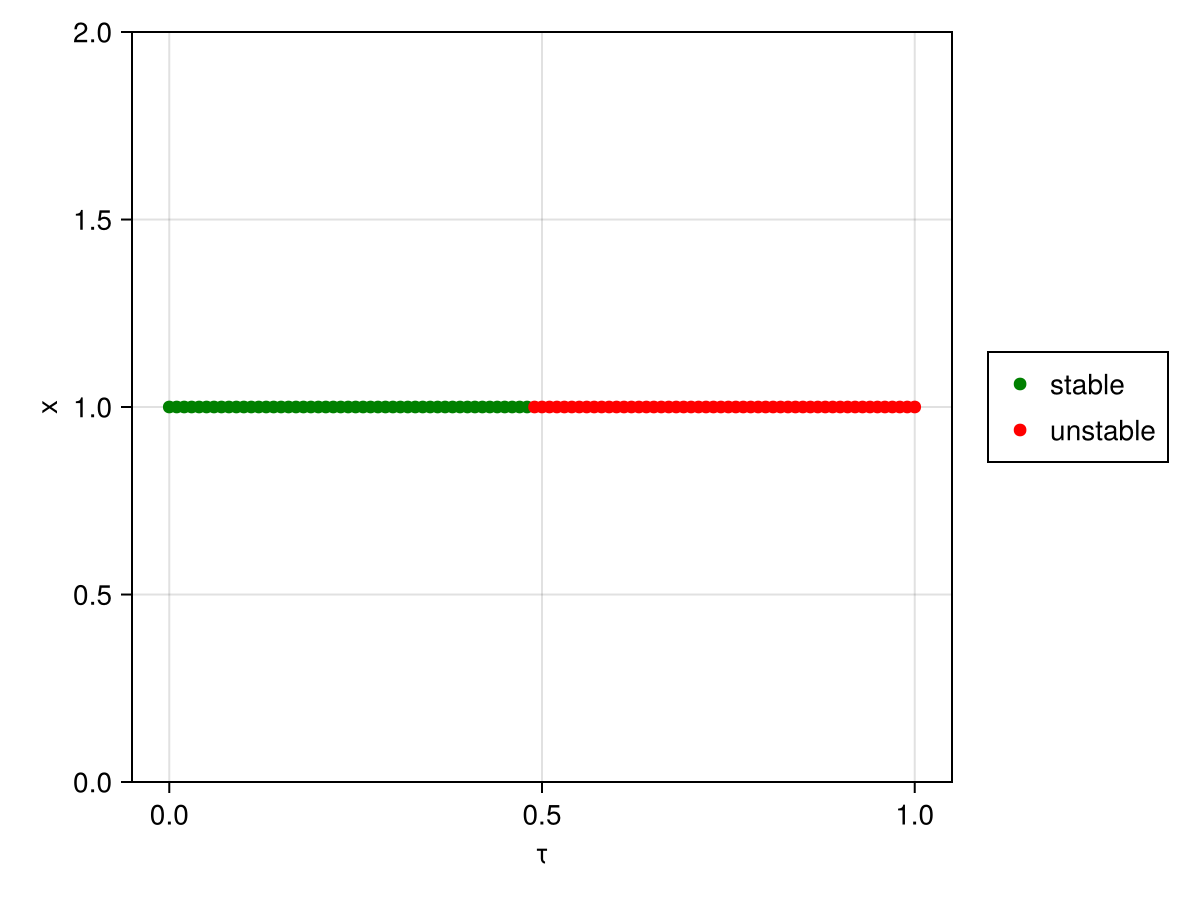

In [50]:
xmat1=hcat([u[1] for u in ylist1]) #finds values of equilibiria points (x)
xlist1=[xmat1[i,:] for i in 1:size(xmat1,1)] #turns values of equilibria points into vector of vectors

plist1=[u[2] for u in ylist1] #Delay value, τ, for each equilibrium point

m=100 #number of discretised steps
nx=1 #number of states 
neq=length(plist1) #number of equilibrium points we're finding the stability of
stab=fill(NaN,neq)

for i in 2:neq
    stab[i]=stab_func(mackeyglassfunc,mackeytau,xlist1[i],[plist1[i]],[beta, gamma,n,tau],[4],nd,doprint=0,m=m)[1] #returns stability of each equilibirum point (1=stable,0=unstable)
end

stab[1]=1.0 #NOTE THIS IS AN EDUCATED GUESS FOR NOW - Need to make my stability function work for it (currently have m/tau=m/0 in stability function for i=1)
stable=(stab.==1.0) #highlights stable indices
unstable=(stab.==0.0) #highlights unstable indices

#Below creates plot to show the stability of the equilibiria
fig2=Figure()
ax2=Axis(fig2[1,1],xlabel="τ",ylabel="x")
scatter!(ax2,plist1[stable],[u[1] for u in xlist1[stable]], color="green", label="stable")
scatter!(ax2,plist1[unstable],[u[1] for u in xlist1[unstable]], color="red", label="unstable")
Legend(fig2[1,2], ax2, merge=true)
fig2


# Hopf Bifurcation

The eigenvalues of the linearised system determine the equilibrium's stability. A Hopf bifurcation occurs when the stability behaviour changes and a pair of complex conugate eigenvalues of the linearised system crosses the imaginary axis and become purely imaginary, i.e. λ=±ω. We start finding the Hopf parameters by finding the initial guess of the τ value for the Hopf bifurcation: 

In [51]:
hopf_indx=findfirst(isequal(0.0), stab) #finds index of initial parameter guess
p_hopf_est=plist1[hopf_indx] #initial guess for τ for Hopf bifurcation

0.49000000000000027

Having found the initial guess for the τ value of the Hopf bifurcation, we now find the ω value and true value of τ for the Hopf bifurcation:

In [52]:
yh01,fhopf=create_hopffunc(mackeyglassfunc,mackeytau,[beta,gamma,n,tau],xlist1[hopf_indx],[plist1[hopf_indx]],[4],nd) #outputs initial guess of the Hopf bifurcation (including x, ω and τ estimates) and a function that contians the method/formula to find the Hopf bifurcation
println("The initial guess for Hopf info: $yh01")
yh1,conv1,=newton_new(fhopf,yh01) #putting initial guess and Hopf function into newton we get the true parameter values and information for the Hopf bifurcation
println("The true information for the Hopf bifurcation: $yh1")
println("converged?: $conv1")
tau_hopf=yh1[end]
om_hopf=yh1[end-1]
x_hopf=yh1[1]
println("The τ value for hopf bifurcation: $tau_hopf")
println("The ω value for hopf bifurcation: $om_hopf")

The initial guess for Hopf info: [1.0, 1.0, 0.0, 3.7503875281389147, 0.49000000000000027]
The true information for the Hopf bifurcation: [1.0, 1.0, 0.0, 3.87298334183115, 0.47081962953876083]
converged?: true
The τ value for hopf bifurcation: 0.47081962953876083
The ω value for hopf bifurcation: 3.87298334183115


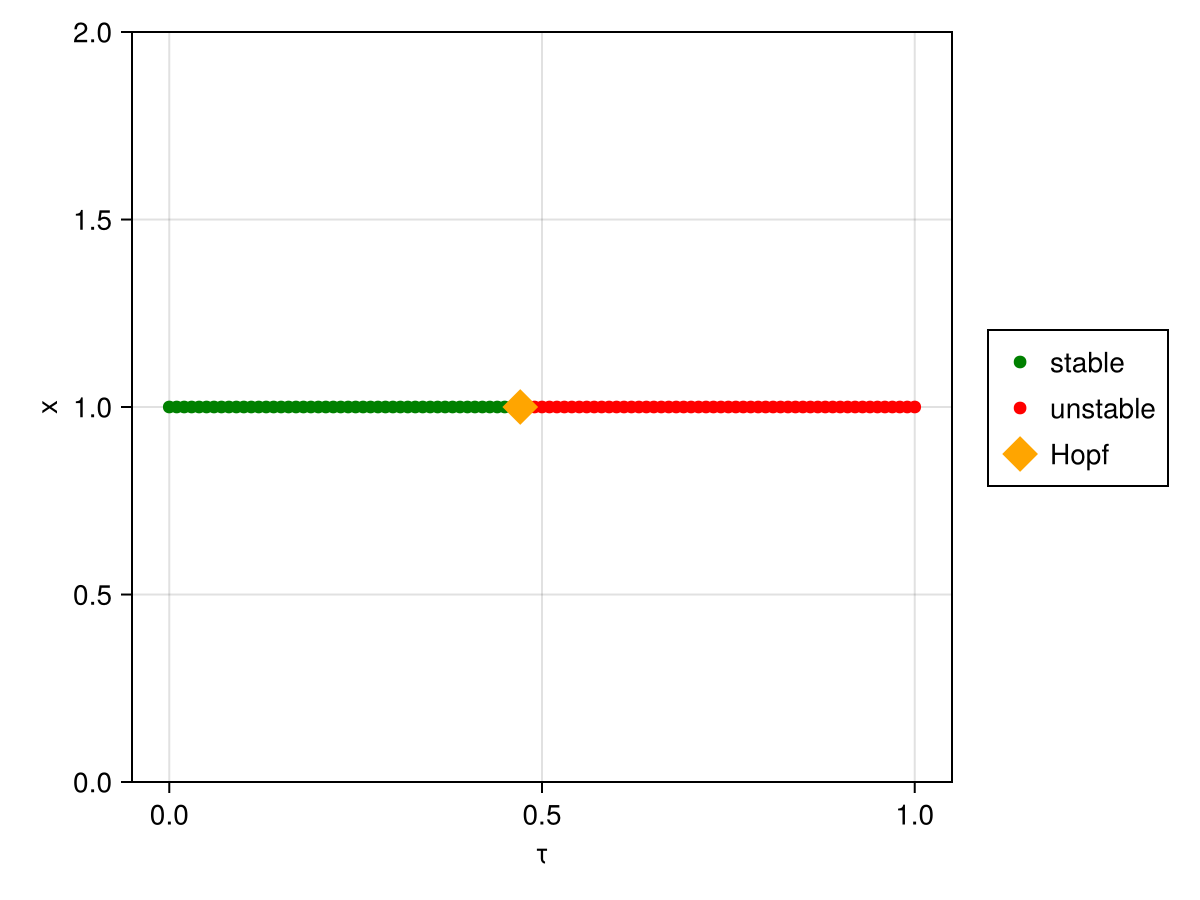

In [53]:
fig3=Figure()
ax3=Axis(fig3[1,1],xlabel="τ",ylabel="x")
scatter!(ax3,plist1[stable],[u[1] for u in xlist1[stable]], color="green", label="stable")
scatter!(ax3,plist1[unstable],[u[1] for u in xlist1[unstable]], color="red",label="unstable")
scatter!(ax3,tau_hopf,x_hopf,marker=:diamond,color=:orange,markersize=:20, label="Hopf")
Legend(fig3[1,2],ax3,merge=true)
fig3

# Continuation in (τ,β)-plane

We continue the Hopf points in the τ and β parameter plane:

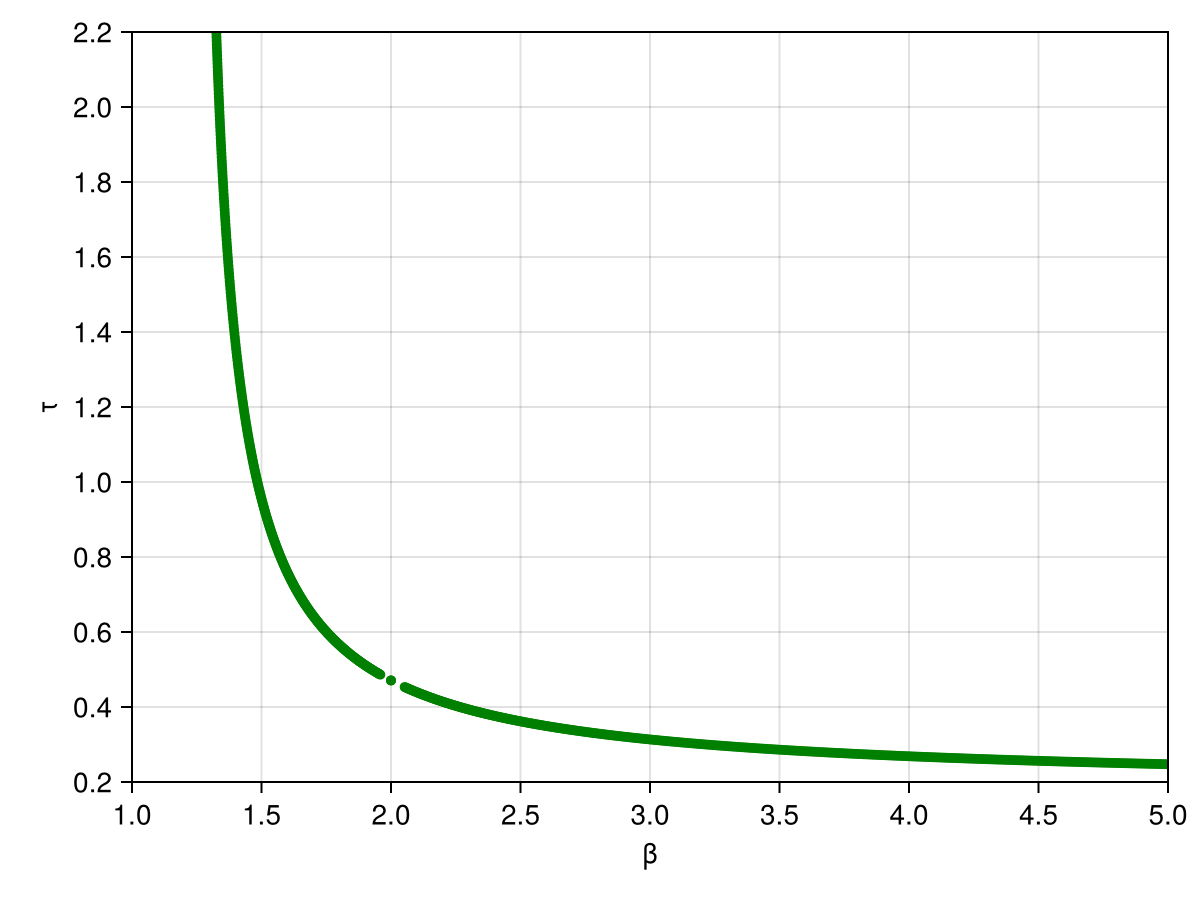

In [ ]:
yheq01,fhopfeq1=create_hopffunc(mackeyglassfunc,mackeytau,[beta,gamma,n,tau_hopf],[x_hopf],[beta,tau_hopf],[1,4],nd)

yheqlist1,heqtan1=track_curve_new(fhopfeq1,yheq01,[-1.0,0,0,0,-1,-1],nmax=500) #tracks beta and tau backwards from beta=2, tau≈0.47
yheqlist2,heqtan2=track_curve_new(fhopfeq1,yheq01,[-1.0,0,0,0,1,1],nmax=500) #tracks beta and tau forwards from beta=2, tau≈0.47

#Plot of continuation/tracking in (a,b) plane
fig4=Figure()
ax4=Axis(fig4[1,1],xlabel="β",ylabel="τ")
scatter!(ax4,[u[end-1] for u in yheqlist1],[u[end] for u in yheqlist1],color="green",markersize=:7)
scatter!(ax4,[u[end-1] for u in yheqlist2],[u[end] for u in yheqlist2],color="green",markersize=:7)
ylims!(ax4,[0.2,2.2])
xlims!(ax4,[1,5])
ax4.xticks=1:0.5:5
ax4.yticks=0.2:0.2:2.2
fig4